In [321]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [322]:
from abc import abstractmethod
import torch
from torch import Tensor, nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np
from collections import OrderedDict, defaultdict

In [323]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'); DEVICE

device(type='cpu')

# Muons

## Muon generation

In [324]:
def generate_batch(n:int) -> Tensor:
    r'''
    Return tensor is (muons, coords),
    coords = (x~Uniform[0,1], y~Uniform[0,1], p=100GeV, theta_x~cos2(a) a~Uniform[0,0.5pi], theta_y~Uniform[0,2pi])
    '''
    
    batch = torch.stack([
        torch.rand(n),
        torch.rand(n),
        torch.zeros(n)+100,
        torch.clamp(torch.randn(n)/10,-math.pi/2,math.pi/2),  # Fix this
        torch.clamp(torch.randn(n)/10,-math.pi/2,math.pi/2)   # Fix this
    ], dim=1)
    return batch

In [325]:
x = generate_batch(10000)

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


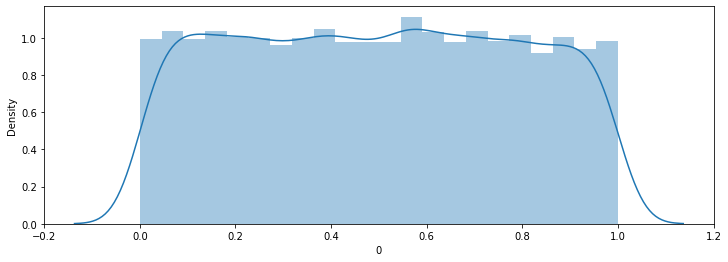

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


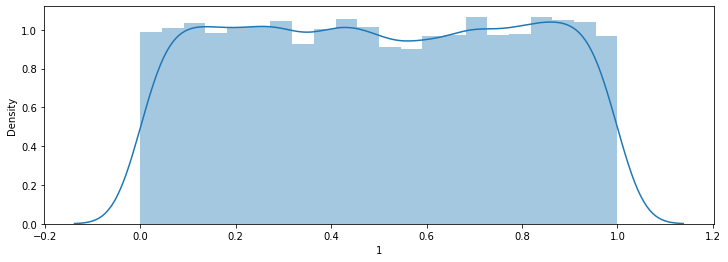

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


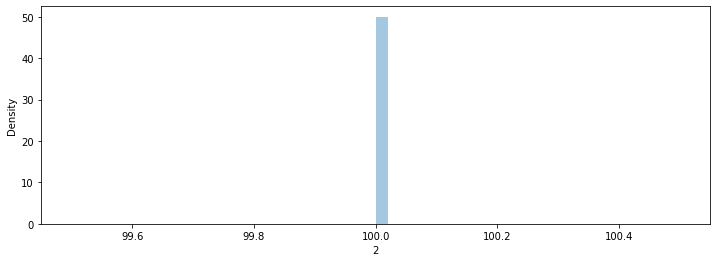

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


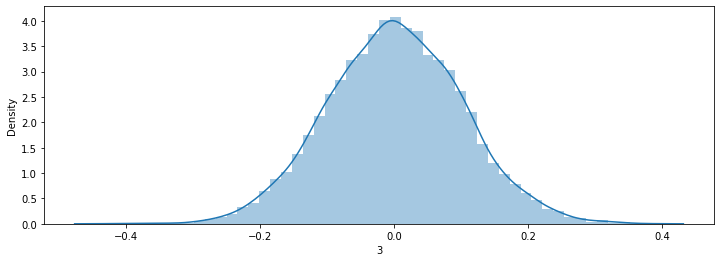

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


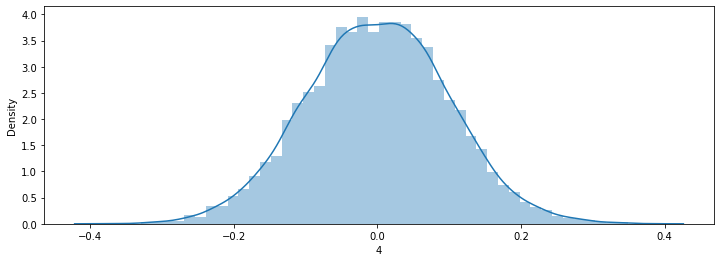

In [326]:
for i in range(x.shape[1]):
    try:
        plt.figure(figsize=(12,4))
        sns.distplot(x[:,i])
        plt.xlabel(i)
        plt.show()
    except RuntimeError:
        pass

In [327]:
m = generate_batch(100)

## Muon Batch

In [328]:
class MuonBatch:
    def __init__(self, muons:Tensor, init_z:float, device:torch.device=DEVICE):
        r'''
        coords = (0:x~Uniform[0,1], 1:y~Uniform[0,1], 2:p=100GeV, 3:theta_x~cos2(a) a~Uniform[0,0.5pi], 4:theta_y~cos2(a) a~Uniform[0,0.5pi]
        '''
        
        self.device = device
        self.muons = muons.to(self.device)
        self.z = Tensor([init_z]).to(self.device)
        self.hits = defaultdict(lambda: defaultdict(list))
        self.xy_hist = OrderedDict({})
        
    def __repr__(self) -> str:
        return f"Batch of {len(self)} muons"
        
    def __len__(self) -> int: return len(self.muons)
    
    @property
    def muons(self) -> Tensor: return self._muons
    
    @muons.setter
    def muons(self, muons:Tensor) -> None: self._muons = muons
        
    @property
    def x(self) -> Tensor: return self._muons[:,0]
    
    @x.setter
    def x(self, x:Tensor) -> None: self._muons[:,0] = x
        
    @property
    def y(self) -> Tensor: return self._muons[:,1]
    
    @y.setter
    def y(self, y:Tensor) -> None: self._muons[:,1] = y
        
    @property
    def xy(self) -> Tensor: return self._muons[:,:2]
    
    @xy.setter
    def xy(self, xy:Tensor) -> None: self._muons[:,:2] = xy
        
    @property
    def p(self) -> Tensor: return self._muons[:,2]
    
    @p.setter
    def p(self, p:Tensor) -> None: self._muons[:,2] = p
        
    @property
    def theta_x(self) -> Tensor: return self._muons[:,3]
    
    @theta_x.setter
    def theta_x(self, theta_x:Tensor) -> None: self._muons[:,3] = theta_x
        
    @property
    def theta_y(self) -> Tensor: return self._muons[:,4]
    
    @theta_y.setter
    def theta_y(self, theta_y:Tensor) -> None: self._muons[:,4] = theta_y
        
    def propagate(self, dz:float) -> None:
        self.x = self.x+(dz*torch.tan(self.theta_x))
        self.y = self.y+(dz*torch.tan(self.theta_y))
        self.z -= dz
        
    def get_xy_mask(self, lw:Tensor) -> Tensor:
        return (self.x >= 0)*(self.x < lw[0])*(self.y >= 0)*(self.y < lw[1])
    
    def snapshot_xyz(self) -> None:
        self.xy_hist[self.z] = self.xy.cpu().detach().clone().numpy()
        
    def append_hits(self, hits:Dict[str,Tensor], pos:str) -> None:
        for k in hits:
            self.hits[pos][k].append(hits[k])
        
    def get_hits(self, lw:Tensor) -> Tensor:
        m = self.get_xy_mask(lw)
        return {p:{c:torch.stack(self.hits[p][c], dim=1)[m] for c in self.hits[p]} for p in self.hits}
    
    def dtheta_x(self, mu:'MuonBatch') -> Tensor:
        return torch.abs(self.theta_x-mu.theta_x)
    
    def dtheta_y(self, mu:'MuonBatch') -> Tensor:
        return torch.abs(self.theta_y-mu.theta_y)
    
    def dr(self, mu:'MuonBatch') -> Tensor:
        return torch.sqrt((self.dtheta_x(mu)**2)+(self.dtheta_y(mu)**2))
    
    def copy(self) -> 'MuonBatch':
        return MuonBatch(self._muons.detach().clone(), init_z=self.z, device=self.device)

In [329]:
batch = MuonBatch(generate_batch(1000), init_z=1)

In [330]:
batch2 = MuonBatch(generate_batch(1000), init_z=1)

In [331]:
d = batch.dtheta_x(batch2); d.min(),d.max()

(tensor(0.0003), tensor(0.4694))

In [332]:
d = batch.dr(batch2); d.min(),d.max()

(tensor(0.0011), tensor(0.5328))

In [333]:
batch.xy

tensor([[0.5374, 0.5002],
        [0.2218, 0.0441],
        [0.8514, 0.3220],
        ...,
        [0.6958, 0.2888],
        [0.0835, 0.8546],
        [0.0132, 0.1118]])

In [334]:
batch.snapshot_xyz()

In [335]:
batch.xy_hist

OrderedDict([(tensor([1.]),
              array([[0.53738534, 0.5002208 ],
                     [0.22177231, 0.04409111],
                     [0.8514335 , 0.32202482],
                     ...,
                     [0.69575816, 0.28883976],
                     [0.08346528, 0.85459924],
                     [0.01319635, 0.11182845]], dtype=float32))])

In [336]:
batch.propagate(0.1)

In [337]:
batch.xy

tensor([[0.5340, 0.4966],
        [0.2197, 0.0521],
        [0.8579, 0.3358],
        ...,
        [0.7113, 0.2968],
        [0.0764, 0.8619],
        [0.0147, 0.1109]])

In [338]:
batch.xy_hist

OrderedDict([(tensor([0.9000]),
              array([[0.53738534, 0.5002208 ],
                     [0.22177231, 0.04409111],
                     [0.8514335 , 0.32202482],
                     ...,
                     [0.69575816, 0.28883976],
                     [0.08346528, 0.85459924],
                     [0.01319635, 0.11182845]], dtype=float32))])

In [339]:
batch.snapshot_xyz()

In [340]:
batch.xy_hist

OrderedDict([(tensor([0.9000]),
              array([[0.53395456, 0.49659285],
                     [0.21974532, 0.05205743],
                     [0.8579235 , 0.3358205 ],
                     ...,
                     [0.71125644, 0.29682177],
                     [0.07641899, 0.86192596],
                     [0.01474513, 0.11085228]], dtype=float32))])

# Volume+Detector

In [341]:
class Layer(nn.Module):
    def __init__(self, lw:Tensor, z:float, size:float, device:torch.device=DEVICE):
        super().__init__()
        self.lw,self.z,self.size,self.device = lw,Tensor([z]),size,device
        self.rad_length = None
        
    def scatter_and_propagate(self, mu:MuonBatch, deltaz:float) -> None:
        """
        This function produces a model of multiple scattering through a layer of material
        of depth deltaz
        
        TODO: Expand to sum over traversed voxels
        """
        
        if self.rad_length is not None:
            mask = mu.get_xy_mask(self.lw)  # Only scatter muons inside volume
            n = mask.sum()
            xy_idx = self.abs2idx(mu, mask)

            x0 = self.rad_length[xy_idx[:,0],xy_idx[:,1]]
            z1 = torch.randn(n, device=self.device)
            z2 = torch.randn(n, device=self.device)

            theta0 = (0.0136/mu.p[mask]) * torch.sqrt(x0) # Ignore due to inversion problems * (1+(0.038*torch.log(x0)))
            theta_msc = math.sqrt(2) * z2 * theta0
            phi_msc = torch.rand(n, device=self.device)*2*math.pi
            dh_msc = deltaz*torch.sin(theta0)*((z1/math.sqrt(12))+(z2/math.sqrt(2)))
            dx_msc = math.sqrt(2) * dh_msc * torch.cos(phi_msc) * torch.cos(mu.theta_x[mask]) # we need to account for direction of incident particle!
            dy_msc = math.sqrt(2) * dh_msc * torch.sin(phi_msc) * torch.cos(mu.theta_y[mask]) # ... so we project onto the surface of the layer

            # Update to position at scattering. Note that if a track incides on a layer
            # with angle theta_mu, the dx and dy displacements are relative to zero angle
            # (generation of MSC formulas are oblivious of angle of incidence) so we need
            # to rescale them by cos of thetax and thetay. 
            # ---------------------------------------------------------------------------
            mu.x[mask]       = mu.x[mask] + dx_msc 
            mu.y[mask]       = mu.y[mask] + dy_msc
            mu.propagate(deltaz)
            mu.theta_x[mask] = mu.theta_x[mask] + theta_msc*torch.cos(phi_msc)
            mu.theta_y[mask] = mu.theta_y[mask] + theta_msc*torch.sin(phi_msc)
        else:
            mu.propagate(deltaz)
        
    def abs2idx(self, mu:MuonBatch, mask:Optional[Tensor]=None) -> Tensor:
        xy = mu.xy
        if mask is not None: xy = xy[mask]
        return torch.floor(xy/self.size).long()
                         
    @abstractmethod
    def forward(self, mu:MuonBatch) -> None: pass

## Volume

In [342]:
X0 = {'beryllium':35.28,
      'carbon':19.32,
      'aluminium':8.897,
      'silicon':9.37,
      'iron':1.757,
      'copper':1.436,
      'lead':0.5612,
     # 'air':31222
     }

In [343]:
def arb_rad_length(z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['aluminium']
    if z >= 0.3 and z <= 0.6: rad_length[3:7,3:7] = X0['lead']
    return rad_length

In [344]:
d = arb_rad_length(0.3, lw=Tensor([1,1]), size=0.1);d

tensor([[8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970,
         8.8970],
        [8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970,
         8.8970],
        [8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970,
         8.8970],
        [8.8970, 8.8970, 8.8970, 0.5612, 0.5612, 0.5612, 0.5612, 8.8970, 8.8970,
         8.8970],
        [8.8970, 8.8970, 8.8970, 0.5612, 0.5612, 0.5612, 0.5612, 8.8970, 8.8970,
         8.8970],
        [8.8970, 8.8970, 8.8970, 0.5612, 0.5612, 0.5612, 0.5612, 8.8970, 8.8970,
         8.8970],
        [8.8970, 8.8970, 8.8970, 0.5612, 0.5612, 0.5612, 0.5612, 8.8970, 8.8970,
         8.8970],
        [8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970,
         8.8970],
        [8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970,
         8.8970],
        [8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970,
         8.8970]])

In [345]:
x = generate_batch(10)

In [346]:
idxs = torch.floor(x[:,:2]/0.1).long()

In [347]:
d[idxs[:,0],idxs[:,1]]

tensor([0.5612, 0.5612, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 8.8970, 0.5612,
        8.8970])

In [348]:
class PassiveLayer(Layer):
    def __init__(self, rad_length_func:Callable[[float,Tensor,float],float],
                 lw:Tensor, z:float, size:float, device:torch.device=DEVICE):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.rad_length = rad_length_func(self.z, self.lw, size=self.size).to(self.device)
                   
    def forward(self, mu:MuonBatch) -> None:
        n = 2
#         mu_0 = mu.copy()
        for _ in range(n):
#             mu_i = mu.copy()
            self.scatter_and_propagate(mu, deltaz=self.size/n)
        
#         # Hack to avoid complicated maths for now
#         dr = {'dr':mu.dr(mu_0), 'z':self.z.expand(len(mu_i)).clone(), 'xy':mu_i.xy}
#         if not hasattr(mu, 'deflections'):
#             mu.deflections = dr
#         else:  # Store largest deviation
#             m = (mu.deflections['dr'] < dr['dr']).squeeze()
#             for k in dr:
#                 mu.deflections[k][m] = dr[k][m]
#         del mu_0,mu_i

In [349]:
vl = PassiveLayer(arb_rad_length, lw=Tensor([1,1]), z=0.5, size=0.1)

In [350]:
batch = MuonBatch(generate_batch(1000), 1.0)

In [351]:
batch.xy

tensor([[0.8615, 0.7021],
        [0.9055, 0.7010],
        [0.5876, 0.5220],
        ...,
        [0.9392, 0.4195],
        [0.5011, 0.4307],
        [0.3536, 0.9684]])

In [352]:
batch.theta_x

tensor([ 9.0910e-02, -7.5431e-02, -9.7422e-03,  1.5102e-01,  6.9695e-02,
        -1.4050e-01,  2.1213e-01,  7.2003e-02, -9.1404e-02,  3.4322e-02,
        -1.0219e-01, -1.4217e-01, -1.2183e-01,  3.4263e-02,  7.4473e-02,
         4.2216e-02, -1.3440e-01,  2.9377e-01,  1.5736e-01, -5.8329e-02,
         8.2825e-02,  1.4186e-01, -4.2392e-02, -5.5858e-02,  1.8363e-01,
        -6.1346e-02, -1.2527e-01, -1.2910e-01,  3.7889e-02, -4.2094e-02,
        -6.2919e-02, -2.7701e-02,  2.1036e-01,  6.8720e-02, -2.8892e-01,
         1.0759e-01, -1.4480e-01,  6.9401e-02, -2.0621e-02,  2.3521e-02,
        -1.3732e-01,  2.0327e-02, -1.0394e-01, -1.1550e-01,  1.7496e-01,
         6.9992e-02, -1.4004e-01,  8.6325e-02,  5.1839e-02,  5.9054e-02,
         5.5185e-02,  7.1092e-02,  1.1485e-01, -6.6278e-02, -2.1007e-01,
         1.7783e-01,  2.0491e-02, -1.2497e-01,  1.7388e-02,  1.4846e-01,
        -1.4865e-01, -5.8005e-02, -5.3019e-02,  2.4087e-02, -7.4784e-02,
        -2.9803e-02, -1.4570e-01, -3.8696e-02,  6.1

In [353]:
batch.z

tensor([1.])

In [354]:
vl(batch)

In [355]:
batch.theta_x

tensor([ 9.0660e-02, -7.6362e-02, -1.0023e-02,  1.5114e-01,  6.9858e-02,
        -1.4106e-01,  2.1225e-01,  7.2139e-02, -9.1875e-02,  3.4112e-02,
        -1.0206e-01, -1.4168e-01, -1.2210e-01,  3.4874e-02,  7.4098e-02,
         4.2142e-02, -1.3439e-01,  2.9279e-01,  1.5688e-01, -5.8464e-02,
         8.3865e-02,  1.4171e-01, -4.2502e-02, -5.5771e-02,  1.8279e-01,
        -6.1232e-02, -1.2505e-01, -1.2913e-01,  3.7922e-02, -4.2589e-02,
        -6.3539e-02, -2.7558e-02,  2.0968e-01,  6.8625e-02, -2.8920e-01,
         1.0751e-01, -1.4536e-01,  6.9039e-02, -2.0577e-02,  2.4339e-02,
        -1.3732e-01,  2.0941e-02, -1.0472e-01, -1.1638e-01,  1.7520e-01,
         6.9569e-02, -1.4016e-01,  8.6803e-02,  5.0425e-02,  5.8962e-02,
         5.5072e-02,  7.0978e-02,  1.1526e-01, -6.6258e-02, -2.1010e-01,
         1.7780e-01,  2.1084e-02, -1.2529e-01,  1.6821e-02,  1.4855e-01,
        -1.4845e-01, -5.7558e-02, -5.3149e-02,  2.4059e-02, -7.4847e-02,
        -2.9861e-02, -1.4578e-01, -3.7522e-02,  6.1

In [356]:
batch.xy

tensor([[0.8706, 0.7030],
        [0.8979, 0.6909],
        [0.5866, 0.4969],
        ...,
        [0.9571, 0.4247],
        [0.4926, 0.4341],
        [0.3643, 0.9662]])

In [357]:
batch.z

tensor([0.9000])

## Detector

### Cost functions

In [358]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

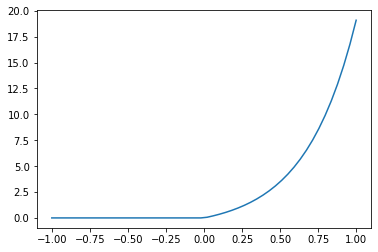

In [359]:
x = torch.linspace(-1,1,50)
plt.plot(x,eff_cost(x))

In [360]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x)**2

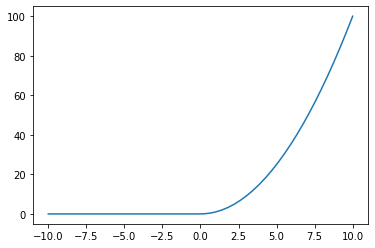

In [361]:
x = torch.linspace(-10,10,50)
plt.plot(x,res_cost(x))

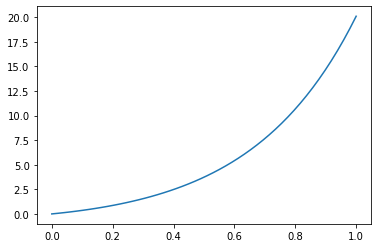

In [362]:
x = torch.linspace(0,1,50)
plt.plot(x,res_cost(x)+eff_cost(x))

### layer

In [363]:
class DetectorLayer(Layer):
    def __init__(self, pos:str, init_res:float, init_eff:float, lw:Tensor, z:float, size:float,
                 eff_cost_func:Callable[[Tensor],Tensor], res_cost_func:Callable[[Tensor],Tensor], device:torch.device=DEVICE):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.pos = pos
        self.resolution = nn.Parameter(torch.zeros(list((self.lw/size).long()), device=self.device)+init_res)
        self.efficiency = nn.Parameter(torch.zeros(list((self.lw/size).long()), device=self.device)+init_eff)
        self.eff_cost_func,self.res_cost_func = eff_cost_func,res_cost_func
        
    def get_hits(self, mu:MuonBatch) -> Dict[str,Tensor]:  # to dense and add precision
        mask = mu.get_xy_mask(self.lw)
        res,eff = torch.zeros(len(mu), device=self.device),torch.zeros(len(mu), device=self.device)  # Zero detection outside detector
        xy_idxs = self.abs2idx(mu, mask)
        res[mask] = self.resolution[xy_idxs[:,0],xy_idxs[:,1]]
        eff[mask] = self.efficiency[xy_idxs[:,0],xy_idxs[:,1]]
        
        # TODO clamp deviation so that reco hit is always inside gen hit's detector element
        hits = {'xy': torch.stack([mu.x+(torch.randn(len(mu), device=self.device)/(torch.abs(res)+1e-17)),  # Inverse resolution
                                   mu.y+(torch.randn(len(mu), device=self.device)/(torch.abs(res)+1e-17))], dim=1),
                'z': self.z.expand_as(mu.x)[:,None]-(self.size/2),
                'eff': eff,  # May not work
                'res': res}  # May not work
        return hits
        
    def forward(self, mu:MuonBatch) -> None:
        self.scatter_and_propagate(mu, self.size/2)
        mu.append_hits(self.get_hits(mu), self.pos)
        self.scatter_and_propagate(mu, self.size/2)
        
    def get_cost(self) -> Tensor:
        return self.eff_cost_func(self.efficiency).sum()+self.res_cost_func(self.resolution).sum()

In [364]:
batch = MuonBatch(generate_batch(1000), 1)

In [365]:
dl = DetectorLayer('above', 1,1,Tensor([1,1]),1,0.1, eff_cost_func=eff_cost, res_cost_func=res_cost)

In [366]:
dl.resolution

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)

In [367]:
dl(batch)
dl(batch)
dl(batch)

In [368]:
hits = batch.get_hits(Tensor([1,1]))

In [369]:
hits['above']['xy'].shape

torch.Size([944, 3, 2])

In [370]:
hits['above']['eff'].shape

torch.Size([944, 3])

# Volume 

In [371]:
class Volume(nn.Module):
    def __init__(self, layers:nn.ModuleList):
        super().__init__()
        self.layers = layers
        
    def get_detectors(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, DetectorLayer)]
    
    def get_passives(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, PassiveLayer)]
    
    def get_rad_cube(self) -> Tensor:
        vols = reversed(self.get_passives())
        return torch.stack([v.rad_length for v in vols], dim=0)
    
    def lookup_coords(self, xyz:Tensor, passive_only:bool) -> Tensor:
        r'''Assume same size for all layers for now and no intermedeate detector layers'''
        if len(xyz.shape) == 1: xyz = xyz[None,:]
        sz = self.layers[0].size
        if passive_only: xyz[:,2] = xyz[:,2]-self.get_passives()[-1].z+sz
        return torch.floor(xyz/sz).long()
            
        
    def forward(self, mu:MuonBatch) -> Tensor:  # Expand to take volume as input, too
        cost = None
        for l in self.layers:
            l(mu)
            mu.snapshot_xyz()
            if hasattr(l, 'get_cost'):  # Get cost of detector layer
                if cost is None:
                    cost = l.get_cost()
                else:
                    cost = cost+l.get_cost()
        return cost

In [372]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [373]:
layers = get_layers()

In [374]:
volume = Volume(layers=layers); volume

Volume(
  (layers): ModuleList(
    (0): DetectorLayer()
    (1): DetectorLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PassiveLayer()
    (8): DetectorLayer()
    (9): DetectorLayer()
  )
)

In [375]:
batch = MuonBatch(generate_batch(1000), init_z=1)

In [376]:
volume(batch)

tensor(4.0000e+08, grad_fn=<AddBackward0>)

In [377]:
hits = batch.get_hits(Tensor([1,1]))

In [378]:
hits['above']['xy'].shape

torch.Size([834, 2, 2])

In [379]:
volume.get_rad_cube().shape

torch.Size([6, 10, 10])

# Atomic number reco

## Compute deviations and scatter locations

In [380]:
def jacobian(y:Tensor, x:Tensor, create_graph=False, allow_unused=True):
    r'''Compute full jacobian matrix for single tensor. Call twice for hessian.
    Copied from https://gist.github.com/apaszke/226abdf867c4e9d6698bd198f3b45fb7 credits: Adam Paszke
    TODO: Fix this to work batch-wise (maybe https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa)'''
    jac = []
    flat_y = y.reshape(-1)
    grad_y = torch.zeros_like(flat_y)
    for i in range(len(flat_y)):
        grad_y[i] = 1.  # may need to use value of flat_y?
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph, allow_unused=allow_unused)
        jac.append(grad_x.reshape(x.shape))
        grad_y[i] = 0.
    return torch.stack(jac).reshape(y.shape + x.shape)

In [381]:
layers

ModuleList(
  (0): DetectorLayer()
  (1): DetectorLayer()
  (2): PassiveLayer()
  (3): PassiveLayer()
  (4): PassiveLayer()
  (5): PassiveLayer()
  (6): PassiveLayer()
  (7): PassiveLayer()
  (8): DetectorLayer()
  (9): DetectorLayer()
)

In [382]:
def compute_scatters(hits:Tensor, volume:Volume) -> Dict[str,Tensor]:
    r'''
    Scatter locations adapted from:
    @MISC {3334866,
        TITLE = {Closest points between two lines},
        AUTHOR = {Brian (https://math.stackexchange.com/users/72614/brian)},
        HOWPUBLISHED = {Mathematics Stack Exchange},
        NOTE = {URL:https://math.stackexchange.com/q/3334866 (version: 2019-08-26)},
        EPRINT = {https://math.stackexchange.com/q/3334866},
        URL = {https://math.stackexchange.com/q/3334866}
    }
    
    What about cases multiple hard scatters put the closest point outside the volume?
    
    TODO: compute weight as product of four efficiencies
    '''
    
    # Hits in layers
    xa0 = torch.cat([hits['above']['xy'][:,0], hits['above']['z'][:,0]], dim=-1) # reco x, reco y, gen z, res
    xa1 = torch.cat([hits['above']['xy'][:,1], hits['above']['z'][:,1]], dim=-1) 
    xb0 = torch.cat([hits['below']['xy'][:,1], hits['below']['z'][:,1]], dim=-1) 
    xb1 = torch.cat([hits['below']['xy'][:,0], hits['below']['z'][:,0]], dim=-1)
    
    # Resolutions (may need to lookup resolution from detector rather than use cached res)
    dets = volume.get_detectors()
    res2 = (1/torch.cat([hits[p]['res'] for p in hits], dim=1)[:,:,None])**2

    # Extrapolate muon-path vectors from hits
    v1 = xa1-xa0  
    v2 = xb1-xb0
    
    # scatter locations
    v3 = torch.cross(v1, v2, dim=1)  # connecting vector perpendicular to both lines
    rhs = xb0-xa0
    lhs = torch.stack([v1, -v2, v3], dim=1).transpose(2,1)
    coefs = torch.linalg.solve(lhs, rhs)  # solve p1+t1*v1 + t3*v3 = p2+t2*v2 => p2-p1 = t1*v1 - t2*v2 + t3*v3
    
    q1 = xa0+(coefs[:,0:1]*v1)  # closest point on v1
    loc = q1+(coefs[:,2:3]*v3/2)  # Move halfway along v3 from q1
    
    # Theta deviations
    theta_a = v1[:,2:3]*torch.arctan(v1[:,:2])
    theta_b = v2[:,2:3]*torch.arctan(v2[:,:2])
    dtheta = torch.abs(theta_a-theta_b)
    
    # xy deviations
    dxy = coefs[:,2:3]*v3[:,:2]
    
    # loc uncertainty
    dloc_dres = torch.stack([jacobian(loc[:,:2], l.resolution).sum((-1,-2)) for l in dets], dim=1)
    loc_unc = torch.sqrt((dloc_dres.pow(2)*res2).sum(1))
    
    # dtheta uncertainty
    ddtheta_dres = torch.stack([jacobian(dtheta, l.resolution).sum((-1,-2)) for l in dets], dim=1)
    dtheta_unc = torch.sqrt((ddtheta_dres.pow(2)*res2).sum(1))
    
    # dxy uncertainty
    ddxy_dres = torch.stack([jacobian(dxy, l.resolution).sum((-1,-2)) for l in dets], dim=1)
    dxy_unc = torch.sqrt((ddxy_dres.pow(2)*res2).sum(1))
    
    # theta_in uncertainty
    dtheta_in_dres = torch.stack([jacobian(theta_a, l.resolution).sum((-1,-2)) for l in dets[:2]], dim=1)
    theta_in_unc = torch.sqrt((dtheta_in_dres.pow(2)*res2[:,:2]).sum(1))
    
    return {'loc':loc, 'loc_unc':loc_unc, 'dtheta':dtheta, 'dtheta_unc':dtheta_unc, 'dxy':dxy, 'dxy_unc':dxy_unc, 'theta_in':theta_a, 'theta_in_unc':theta_in_unc}

In [383]:
scatters = compute_scatters(hits, volume)

In [384]:
scatters['loc']

tensor([[0.0766, 0.3661, 0.5440],
        [0.0340, 1.0332, 1.3525],
        [0.8215, 0.7999, 1.0478],
        ...,
        [0.8646, 0.0112, 0.3415],
        [0.5557, 0.3651, 0.1114],
        [0.8138, 0.8828, 1.2099]], grad_fn=<AddBackward0>)

In [385]:
scatters['loc_unc']

tensor([[2.6927e-08, 5.2756e-08],
        [5.9728e-08, 4.1786e-07],
        [1.6806e-08, 1.8964e-08],
        ...,
        [2.0941e-08, 4.1957e-09],
        [4.2929e-08, 1.7657e-08],
        [6.9232e-08, 3.6887e-08]], grad_fn=<SqrtBackward>)

In [386]:
scatters['dtheta']

tensor([[2.7931e-04, 4.5524e-05],
        [1.2372e-04, 5.2612e-05],
        [1.9315e-04, 4.9066e-05],
        ...,
        [5.3132e-04, 2.9828e-05],
        [1.3704e-04, 8.2044e-05],
        [2.0996e-04, 1.3862e-04]], grad_fn=<AbsBackward>)

In [387]:
scatters['dxy']

tensor([[-0.0019,  0.0117],
        [ 0.0029, -0.0069],
        [-0.0007,  0.0028],
        ...,
        [-0.0004,  0.0071],
        [-0.0011, -0.0019],
        [-0.0002, -0.0002]], grad_fn=<MulBackward0>)

In [388]:
scatters['theta_in']

tensor([[-5.1976e-04,  1.3744e-03],
        [ 3.3191e-04,  2.1892e-03],
        [-2.1824e-04, -3.0117e-04],
        ...,
        [ 1.3442e-03,  4.9644e-05],
        [-9.4347e-04, -5.0671e-04],
        [ 1.1302e-03, -5.2786e-04]], grad_fn=<MulBackward0>)

In [389]:
scatters['theta_in_unc']

tensor([[8.9194e-11, 1.2245e-10],
        [1.7412e-10, 1.7679e-10],
        [1.9248e-10, 5.7956e-11],
        ...,
        [9.9323e-11, 1.4699e-10],
        [9.5895e-11, 1.1981e-11],
        [2.2417e-10, 1.4260e-10]], grad_fn=<SqrtBackward>)

In [390]:
n = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

In [391]:
n.cdf(Tensor([[2],[-2]]))

tensor([[0.9772],
        [0.0228]])

In [392]:
hits['above']['z'].shape

torch.Size([834, 2, 1])

In [393]:
np.hstack([hits['above']['z'][0,:,0].detach().cpu().numpy(),hits['below']['z'][0,:,0].detach().cpu().numpy()])

array([0.95      , 0.84999996, 0.14999981, 0.04999978], dtype=float32)

In [394]:
np.hstack([hits['above']['xy'][0,:,0].detach().cpu().numpy(),hits['below']['xy'][0,:,0].detach().cpu().numpy()])

array([0.05650196, 0.0616996 , 0.10707352, 0.11506442], dtype=float32)

In [395]:
def plot_hits(idx:int, hits:Tensor, scatter_locs:Tensor) -> None:
    x = np.hstack([hits['above']['xy'][idx,:,0].detach().cpu().numpy(),hits['below']['xy'][idx,:,0].detach().cpu().numpy()])
    y = np.hstack([hits['above']['xy'][idx,:,1].detach().cpu().numpy(),hits['below']['xy'][idx,:,1].detach().cpu().numpy()])
    z = np.hstack([hits['above']['z'][idx,:,0].detach().cpu().numpy(),hits['below']['z'][idx,:,0].detach().cpu().numpy()])
    scatter = scatter_locs[idx].detach().cpu().numpy()
    fig,axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].scatter(x,z)
    axs[0].scatter(scatter[0], scatter[2])
    axs[0].set_xlim(0,1)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('z')
    axs[1].scatter(y,z)
    axs[1].scatter(scatter[1], scatter[2])
    axs[1].set_xlim(0,1)
    axs[1].set_xlabel('y')
    axs[1].set_ylabel('z')
    plt.show

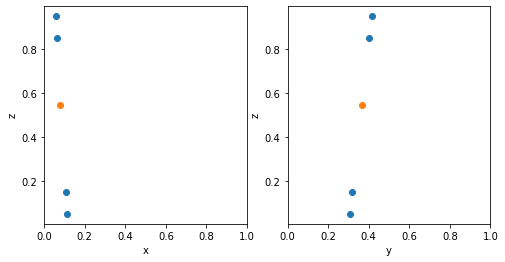

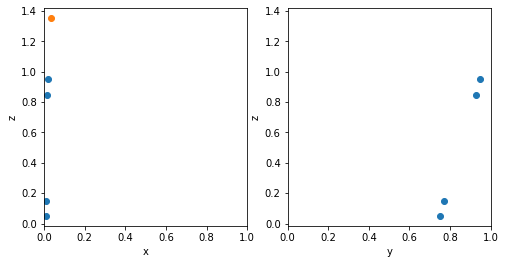

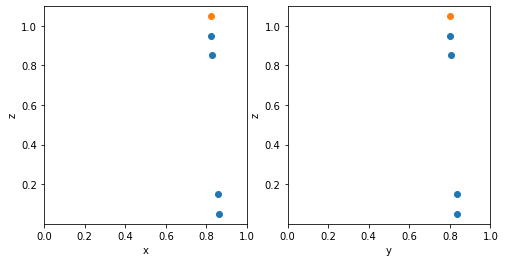

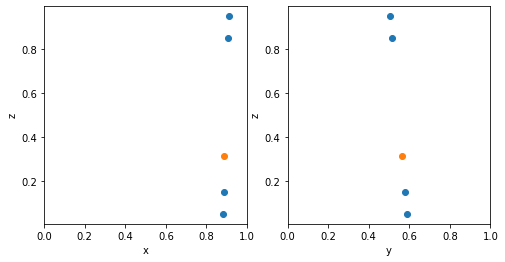

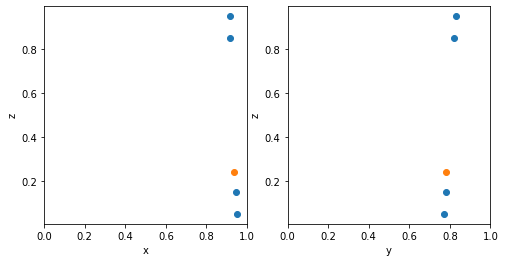

In [396]:
for i in range(5): plot_hits(i, hits, scatters['loc'])

## Infer rad length

### Preds per muon

In [416]:
mask = (scatters['loc'][:,2] >= 0.2)*(scatters['loc'][:,2] < 0.8)

In [417]:
a = 0.038
b = 0.0136
p = batch.p[batch.get_xy_mask(Tensor([1,1]))][mask]

In [418]:
# X0 from dtheta # Debias by considering each voxel on muon paths
theta2 = scatters['dtheta'][mask].pow(2).sum(1)
theta2_unc = (2*scatters['dtheta'][mask]*scatters['dtheta_unc'][mask]).pow(2).sum(1).sqrt()
x0_pred_dtheta = 0.5*theta2*((p/b)**2)  
x0_pred_dtheta_unc = 0.5*theta2_unc*((p/b)**2)

In [419]:
x0_pred_dtheta[:10], x0_pred_dtheta_unc[:10]

(tensor([2.1650, 1.1550, 5.3492, 1.8239, 0.5713, 2.5238, 2.5558, 1.8922, 2.9087,
         3.5443], grad_fn=<SliceBackward>),
 tensor([2.0934e-06, 1.8230e-06, 5.5925e-06, 2.5348e-06, 1.9749e-06, 2.5282e-06,
         3.3060e-06, 2.2184e-06, 3.4743e-06, 4.6229e-06],
        grad_fn=<SliceBackward>))

In [420]:
size = 0.1
dxy = torch.sqrt(scatters['dxy'][mask].pow(2).sum(1))
dh = dxy/((math.sqrt(2)*torch.cos(scatters['theta_in'][mask].pow(2).sum(1)))+1e-17)
theta0 = torch.arcsin(dh/size)
x0_pred_dxy = (theta0*p/b)**2

In [421]:
x0_pred_dxy[:10]

tensor([3.7890e+05, 1.7836e+05, 6.6858e+05, 1.4419e+05, 2.2008e+03, 7.9639e+04,
        2.1493e+00, 1.1636e+05, 3.3974e+05, 9.9157e+04],
       grad_fn=<SliceBackward>)

### Preds per voxel

In [422]:
loc, loc_unc, x0, x0_unc = scatters['loc'][mask][0], scatters['loc_unc'][mask][0], x0_pred_dtheta[0], x0_pred_dtheta_unc[0]

In [423]:
loc, loc_unc

(tensor([0.0766, 0.3661, 0.5440], grad_fn=<SelectBackward>),
 tensor([2.6927e-08, 5.2756e-08], grad_fn=<SelectBackward>))

In [424]:
loc_idx = volume.lookup_coords(loc, passive_only=True).long(); loc_idx

tensor([[0, 3, 3]])

In [425]:
rad_pred = nn.init.zeros_(volume.get_rad_cube())
weights = rad_pred.clone()

In [426]:
rad_pred[loc_idx[:,2],loc_idx[:,0],loc_idx[:,1]] = x0*x0_unc
weights[loc_idx[:,2],loc_idx[:,0],loc_idx[:,1]] = x0_unc

In [427]:
rad_pred

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0

In [428]:
rad_pred.shape

torch.Size([6, 10, 10])

In [429]:
rad_pred = rad_pred/weights

In [430]:
rad_pred

tensor([[[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan],
         [   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,

In [431]:
loc, loc_unc, x0, x0_unc = scatters['loc'][mask], scatters['loc_unc'][mask], x0_pred_dtheta, x0_pred_dtheta_unc

In [432]:
loc, loc_unc

(tensor([[0.0766, 0.3661, 0.5440],
         [0.8872, 0.5658, 0.3144],
         [0.9358, 0.7828, 0.2416],
         ...,
         [0.7613, 0.3198, 0.5663],
         [0.5897, 0.1513, 0.2231],
         [0.8646, 0.0112, 0.3415]], grad_fn=<IndexBackward>),
 tensor([[2.6927e-08, 5.2756e-08],
         [1.4346e-08, 3.9287e-08],
         [1.3994e-08, 1.7483e-08],
         [8.9094e-09, 2.5185e-08],
         [2.1640e-08, 1.5781e-08],
         [2.9238e-08, 3.0718e-08],
         [2.2259e-08, 6.6335e-09],
         [1.8604e-08, 1.6197e-08],
         [6.0713e-08, 3.3487e-08],
         [3.8781e-09, 7.1843e-09],
         [1.2061e-07, 6.8353e-09],
         [1.7641e-08, 7.6553e-08],
         [7.3341e-07, 2.7224e-08],
         [6.6625e-09, 3.3226e-09],
         [5.6786e-08, 4.3184e-08],
         [3.0972e-09, 1.4244e-08],
         [1.1962e-08, 7.8068e-08],
         [6.1653e-08, 3.8239e-08],
         [7.5580e-09, 6.9060e-08],
         [4.1298e-09, 2.8596e-09],
         [1.6705e-08, 5.3301e-08],
         [1.43

In [433]:
loc_idx = volume.lookup_coords(loc, passive_only=True); loc_idx

tensor([[0, 3, 3],
        [8, 5, 1],
        [9, 7, 0],
        ...,
        [7, 3, 3],
        [5, 1, 0],
        [8, 0, 1]])

In [434]:
rad_pred = nn.init.zeros_(volume.get_rad_cube())
weights = rad_pred.clone()

In [435]:
loc.max(0),loc_idx.max(0)

(torch.return_types.max(
 values=tensor([0.9897, 0.9987, 0.5991], grad_fn=<MaxBackward0>),
 indices=tensor([  9,  88, 391])),
 torch.return_types.max(
 values=tensor([9, 9, 5]),
 indices=tensor([ 2, 12,  4])))

In [436]:
rad_pred[loc_idx[:,2],loc_idx[:,0],loc_idx[:,1]] = x0*x0_unc
weights[loc_idx[:,2],loc_idx[:,0],loc_idx[:,1]] = x0_unc

In [437]:
rad_pred

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          4.5925e-06, 0.0000e+00, 0.0000e+00, 3.7427e-06, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 3.7540e-06, 0.0000e+00, 1.9709e-07,
          0.0000e+00, 3.2648e-05, 4.2096e-05, 9.8554e-07, 1.1254e-05],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.8486e-09, 0.0000e+00,
          1.2945e-06, 6.5478e-07, 0.0000e+00, 0.0000e+00, 1.2406e-07],
         [1.2868e-05, 0.0000e+00, 7.9330e-06, 0.0000e+00, 0.0000e+00,
          6.2080e-06, 8.0353e-07, 0.0000e+00, 2.2212e-06, 0.0000e+00],
         [9.3669e-06, 0.0000e+00, 8.7514e-06, 0.0000e+00, 1.0602e-05,
          0.0000e+00, 0.0000e+00, 4.7029e-06, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 2.2171e-05, 0.0000e+00, 6.7624e-06, 0.0000e+00,
          7.0762e-06, 1.6822e-05, 0.0000e+00, 8.9120e-06, 7.1687e-07],
         [0.0000e+00, 1.1834e-07, 1.3441e-05, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6667e-06, 2.7141e-10],
         [0.0

In [438]:
rad_pred.shape

torch.Size([6, 10, 10])

In [439]:
rad_pred = rad_pred/weights

In [440]:
rad_pred

tensor([[[       nan,        nan,        nan,        nan,        nan,
          1.7091e+00,        nan,        nan, 1.4293e+00,        nan],
         [       nan,        nan, 1.3933e+00,        nan, 3.0919e-01,
                 nan, 4.7332e+00, 6.2830e+00, 6.8001e-01, 3.0655e+00],
         [       nan,        nan,        nan, 2.4996e-02,        nan,
          8.9575e-01, 6.2930e-01,        nan,        nan, 2.3988e-01],
         [3.0301e+00,        nan, 2.6640e+00,        nan,        nan,
          2.1585e+00, 5.4968e-01,        nan, 1.0557e+00,        nan],
         [2.7392e+00,        nan, 2.6548e+00,        nan, 2.9867e+00,
                 nan,        nan, 1.8803e+00,        nan,        nan],
         [       nan, 3.6393e+00,        nan, 1.9146e+00,        nan,
          2.3776e+00, 3.6646e+00,        nan, 2.8491e+00, 6.5580e-01],
         [       nan, 2.0507e-01, 3.3195e+00,        nan,        nan,
                 nan,        nan,        nan, 7.9785e-01, 5.5564e-03],
         [   

In [441]:
rad_true = volume.get_rad_cube()

In [448]:
m = rad_pred == rad_pred
torch.abs(rad_pred[m]-rad_true[m]).mean()

tensor(5.6270, grad_fn=<MeanBackward0>)

# Loss

preselect voxels with sufficient illumination

In [ ]:
class DetectorLoss(nn.Module):
    def __init__(self, cost_coef:float):
        super().__init__()
        self.cost_coef = cost_coef
        
    def get_hit_loss(self, mu:MuonBatch) -> Tensor:
        
        
    def forward(self, mu:MuonBatch, cost:Tensor) -> Tensor:
        loss = self.get_hit_loss(mu)
        loss = loss+(self.cost_coef*cost)
        return loss